In [1]:
# handle bugs in some docker container: 'pip install -e .'  doesn't work 
try:
    import Flamingo
except ModuleNotFoundError:
    import sys 
    sys.path.append('..')
    import Flamingo
lang_encoder_path = "facebook/opt-125m"
tokenizer_path = lang_encoder_path
cache_dir = None 
model_config = dict(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path=lang_encoder_path,
    tokenizer_path=tokenizer_path,
    cross_attn_every_n_layers=1,
    cache_dir = cache_dir,
    lora_tuning=False,
    decoupled=True  
)

import torch
from Flamingo.lora_tuning import create_model_and_transforms 
from Flamingo.models.batchprocessor import DecoupledFlamingoBatchProcessor
from Flamingo.datasets.gtsrb import classes
from Flamingo.config.baseline import dataset_config
from Flamingo.datasets import build_dataset
from Flamingo.inference.vis import show_pred_with_gt
from Flamingo.inference import post_process
import pandas as pd 
import pdb
import re

[2024-03-12 17:23:11,865] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# build model, image processor and tokenizer
model, image_processor, tokenizer = create_model_and_transforms(
    **model_config
)
print("Load state dict:")
state_dict = torch.load("/root/yunzhi/flamingo_retrieval/retrieval/work_dir/100/weight.pth")
keys1 = model.lang_encoder.gated_cross_attn_layers.load_state_dict(state_dict, strict=False)
keys2 = model.perceiver.load_state_dict(state_dict, strict=False)
dataset = build_dataset(
    dataset_config=dataset_config,
    vis_processor=image_processor,
    tokenizer=tokenizer)
# model = model.to(device="cuda:2", dtype=torch.bfloat16)

# batch_processor = DecoupledFlamingoBatchProcessor(cast_type='bf16', tokenizer=tokenizer)

Flamingo will use single GPU or CPU

[@rank-1|create Flamingo] create vision_encoder and image_processor from open_clip

[@rank-1|create Flamingo] create text_tokenizer

[@rank-1|create Flamingo] create LLM from  facebook/opt-125m

[@rank-1|create Flamingo] create Flamingo with cross_attn_every_n_layers= 1

[@rank-1|create Flamingo] load checkpoint.pt from huggingface

[@rank-1|create Flamingo] Freeze all parameters

[@rank-1|create Flamingo] LoRa tuning mode:  False

[@rank-1|set requires_grad] No LoRA adaptor, unfrozen the gate cross attention layer

[@rank-1|set requires_grad] unfrozen perceiver layer

root
├── model (OPTModel)
│   └── decoder (OPTDecoder)
│       ├── embed_tokens (Embedding) weight:[50267, 768]
│       ├── embed_positions (OPTLearnedPositionalEmbedding) weight:[2050, 768]
│       ├── final_layer_norm (LayerNorm) weight:[768] bias:[768]
│       └── layers (ModuleList)
│           └── 0-11(FlamingoLayer)
│               ├── gated_cross_attn_layer (GatedCrossAttentionBlock) attn_gate:[1] ff_gate:[1]
│               │   ├── attn (MaskedCrossAttention)
│               │   │   ├── norm (LayerNorm) weight:[768] bias:[768]
│               │   │   ├── to_q (Linear) weight:[512, 768]
│               │   │   ├── to_kv (Linear) weight:[1024, 1024]
│               │   │   └── to_out (Linear) weight:[768, 512]
│               │   └── ff (Sequential)
│               │       ├── 0 (LayerNorm) weight:[768] bias:[768]
│               │       ├── 1 (Linear) weight:[3072, 768]
│               │       └── 3 (Linear) weight:[768, 3072]
│               └── decoder_layer (OPTDecoderLayer)
│                   ├── self_attn (OPTAttention)
│                   │   └── k_proj,v_proj,q_proj,out_proj(Linear) weight:[768, 768] bias:[768]
│                   ├── self_attn_layer_norm,final_layer_norm(LayerNorm) weight:[768] bias:[768]
│                   ├── fc1 (Linear) weight:[3072, 768] bias:[3072]
│                   └── fc2 (Linear) weight:[768, 3072] bias:[768]
├── lm_head (Linear) weight:[50267, 768]
├── old_decoder_blocks (ModuleList)
│   └── 0-11(OPTDecoderLayer)
│       ├── self_attn (OPTAttention)
│       │   └── k_proj,v_proj,q_proj,out_proj(Linear) weight:[768, 768] bias:[768]
│       ├── self_attn_layer_norm,final_layer_norm(LayerNorm) weight:[768] bias:[768]
│       ├── fc1 (Linear) weight:[3072, 768] bias:[3072]
│       └── fc2 (Linear) weight:[768, 3072] bias:[768]
└── gated_cross_attn_layers (ModuleList)
    └── 0-11(GatedCrossAttentionBlock) attn_gate:[1] ff_gate:[1]
        ├── attn (MaskedCrossAttention)
        │   ├── norm (LayerNorm) weight:[768] bias:[768]
        │   ├── to_q (Linear) weight:[512, 768]
        │   ├── to_kv (Linear) weight:[1024, 1024]
        │   └── to_out (Linear) weight:[768, 512]
        └── ff (Sequential)
            ├── 0 (LayerNorm) weight:[768] bias:[768]
            ├── 1 (Linear) weight:[3072, 768]
            └── 3 (Linear) weight:[768, 3072]

Flamingo model initialized with 171MB trainable parameters

Load state dict:


In [11]:
model.perceiver(torch.rand(2, 1, 3, 256, 1024)).shape

torch.Size([2, 1, 64, 1024])

In [3]:
cats = [classes[k] for k in classes]

In [4]:
data = dataset.random_input25()  


In [5]:
with torch.inference_mode():
    output = batch_processor(model=model, batch=data['vision_x'], mode='test',
            text_prompt="<image>Output:", num_beams=3, max_new_tokens=20)
    print("before post process:", output)
    output = post_process(output, cats=cats)
output

before post process: ["Output:Speed limit (30km/h)�I'm not sure if this is a joke or", "Output:Speed limit (70km/h)�I'm not sure if I'm going to be", 'Output:Speed limit (50km/h)', "Output:Speed limit (70km/h)\x7fI'm not a fan of speed limit (70", "Output:Pedestrians guiActiveUnI'm a big fan of the Pedestrians\nPedestrians are", "Output:Speed limit (120km/h)\x7fI'm not sure if I should be in the", "Output:Speed limit (70km/h) guiActiveUnI'm not sure if this is a joke or", "Output:Road work guiActiveUnI'm driving now\nRoad work\nRoad work\nRoad work\nRoad work", "Output:Yield guiActiveUnI'm a sucker for ice/snow guiActiveUnYield\n\nY", "Output:General caution�I'm a fan of the general caution<mask>I'm a fan of the", "Output:Keep right guiActiveUnI'm not sure if I'll be able to keep right�I'm", "Output:General caution guiActiveUnI'm a general caution�I like it.\nI like it.", 'Output:Yield', "Output:Road work guiActiveUnI'm not sure how to drive\nRoad work guiActiveUnI'm not sure", 'Output

['Speed limit (30km/h)',
 'Speed limit (70km/h)',
 'Speed limit (50km/h)',
 'Speed limit (70km/h)',
 'Pedestrians',
 'Speed limit (120km/h)',
 'Speed limit (70km/h)',
 'Road work',
 'Yield',
 'General caution',
 'Keep right',
 'General caution',
 'Yield',
 'Road work',
 'Speed limit (70km/h)',
 'End of speed limit (80km/h)',
 'Yield',
 'Priority road',
 'Speed limit (100km/h)',
 'Go straight or right',
 'Speed limit (60km/h)',
 'No passing',
 'End of speed limit (80km/h)',
 'No passing veh over 3.5 tons',
 'Speed limit (60km/h)']

In [6]:
# 查看显存占用
torch.cuda.memory_allocated() // (1024 * 1024),torch.cuda.max_memory_allocated() // (1024 * 1024)

(270, 270)

In [7]:
table = pd.DataFrame({
    "pred":output,
    "gt":data['labels']
})
table

,pred,gt
0,Speed limit (30km/h),Speed limit (30km/h)
1,Speed limit (70km/h),Speed limit (70km/h)
2,Speed limit (50km/h),Speed limit (50km/h)
3,Speed limit (70km/h),Speed limit (70km/h)
4,Pedestrians,Pedestrians
5,Speed limit (120km/h),Speed limit (120km/h)
6,Speed limit (70km/h),Speed limit (70km/h)
7,Road work,Road work
8,Yield,Yield
9,General caution,General caution


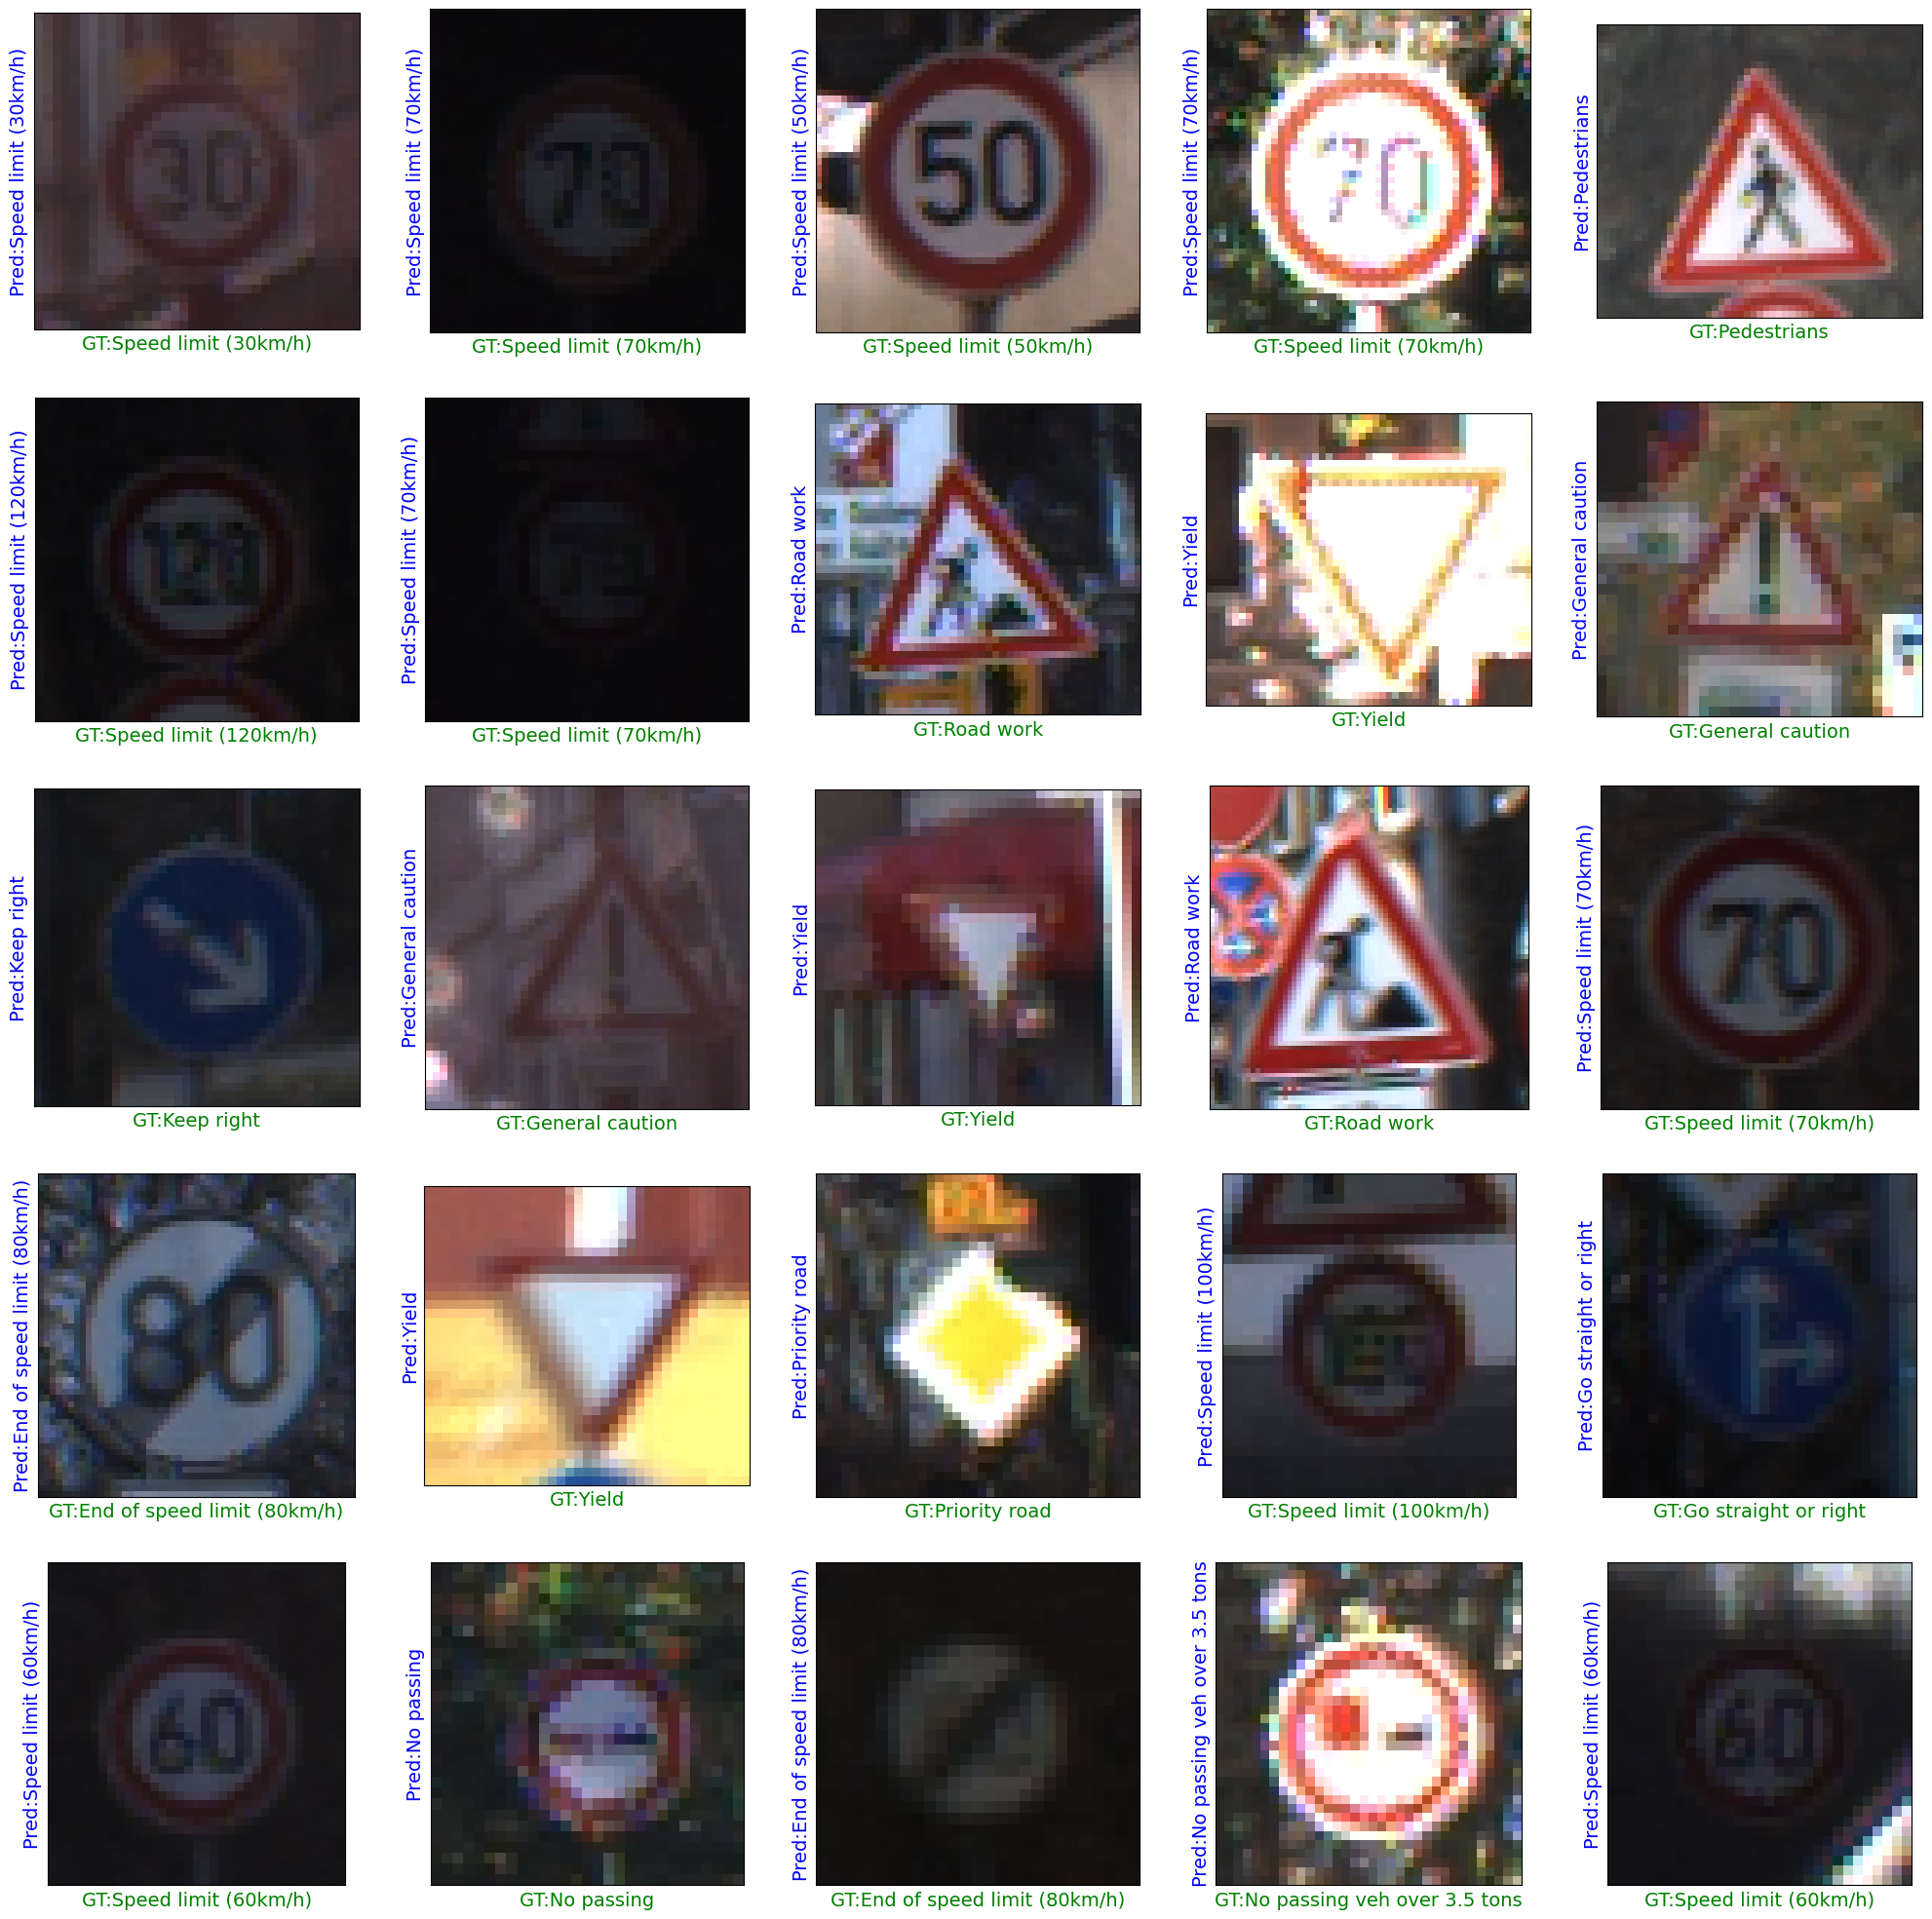

In [8]:
show_pred_with_gt(imgs=data['imgs'], preds=output, gts=data['labels'])

In [9]:
""" 
see training log:
loss is close to 0
"""
!tail -n 20 /root/yunzhi/flamingo_retrieval/retrieval/work_dir/[2024-01-10][22:54:19]PID:64834.log

2024-01-11 06:37:27.622 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:230|409] Dataset: GTSRB, Loss: 8.940696716308594e-07
2024-01-11 06:37:34.273 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:240|409] Dataset: GTSRB, Loss: 6.109476089477539e-07
2024-01-11 06:37:40.628 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:250|409] Dataset: GTSRB, Loss: 6.966292858123779e-07
2024-01-11 06:37:47.428 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:260|409] Dataset: GTSRB, Loss: 2.9616057872772217e-07
2024-01-11 06:37:54.189 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:270|409] Dataset: GTSRB, Loss: 7.636845111846924e-07
2024-01-11 06:38:01.352 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:28

In [18]:
# import sentence_transformers
# output[14],data['labels'][1]